In [21]:
import os
import sys
current_directory = os.getcwd()
if not os.path.exists(current_directory + '\\experimental_data'):
    os.makedirs(current_directory + '\\experimental_data')
    os.makedirs(current_directory + '\\experimental_data\\plots')
    os.makedirs(current_directory + '\\experimental_data\\results')
sys.path.append(current_directory.replace('experiments', ''))
import warnings
import matplotlib.pyplot as plt
# warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
from run import execute_simulation, create_experiment_snapshots, execute_ai_model, single_mtd_simulation, mtd_ai_simulation, multiple_mtd_simulation, specific_multiple_mtd_simulation
from mtdnetwork.mtd.completetopologyshuffle import CompleteTopologyShuffle
from mtdnetwork.mtd.ipshuffle import IPShuffle
from mtdnetwork.mtd.hosttopologyshuffle import HostTopologyShuffle
from mtdnetwork.mtd.portshuffle import PortShuffle
from mtdnetwork.mtd.osdiversity import OSDiversity
from mtdnetwork.mtd.servicediversity import ServiceDiversity
from mtdnetwork.mtd.usershuffle import UserShuffle
from mtdnetwork.mtd.osdiversityassignment import OSDiversityAssignment
import logging
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import matplotlib.cm as cm

logging.basicConfig(format='%(message)s', level=logging.INFO)

# import absl.logging
# absl.logging.set_verbosity(absl.logging.FATAL)

import concurrent.futures

In [22]:
# Learning Parameters
epsilon = 1.0  # exploration rate

# Simulator Settings
start_time = 0
finish_time = 15000
mtd_interval = [200]
network_size = [150]
total_nodes = 150
new_network = True

trial = 1

mtd_strategies = [
    CompleteTopologyShuffle,
    # HostTopologyShuffle,
    IPShuffle,
    OSDiversity,
    # PortShuffle,
    # OSDiversityAssignment,
    ServiceDiversity,
    # UserShuffle
]

result_head_path = ''

In [23]:
class Experiment:
    def __init__(self, epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network, model, trial, result_head_path, file_name=None, attacker_sensitivity=1):
        # Learning Parameters
        self.epsilon = epsilon  # exploration rate

        # Simulator Settings
        self.start_time = start_time
        self.finish_time = finish_time
        self.schemes = [ 'mtd_ai', 'simultaneous', 'random', 'alternative']
        self.total_nodes = total_nodes
        self.new_network = new_network
        self.model = model
        self.trial = trial
        self.model_path = f"AI_model/models_joo_kai/main_network_{model}.h5"
        self.mtd_strategies = [
            CompleteTopologyShuffle,
            # HostTopologyShuffle,
            IPShuffle,
            OSDiversity,
            # PortShuffle,
            # OSDiversityAssignment,
            ServiceDiversity,
            # UserShuffle
        ]
        self.mtd_interval = mtd_interval
        self.network_size = network_size
        self.result_head_path = result_head_path
        self.attacker_sensitivity = attacker_sensitivity

        if file_name is not None:
            self.file_name = file_name
        else:
            self.file_name = self.model


    def run_trials(self, scheme):
        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = []

            for i in range(self.trial):
                if i % 10 == 0:
                    print("Trial_", i)

                if scheme == 'nomtd':
                    # mtd = single_mtd_simulation("nomtd", [None], 
                    #                                             mtd_interval=self.mtd_interval,network_size=self.network_size) 
                    futures.append(executor.submit(single_mtd_simulation, "nomtd", [None], 
                                                                mtd_interval=self.mtd_interval,network_size=self.network_size))
                elif scheme == 'mtd_ai':
                    # try:
                    #     mtd = mtd_ai_simulation(self.model, self.model_path, start_time, finish_time, total_nodes, new_network = new_network, 
                    #                                              mtd_interval=self.mtd_interval,network_size=self.network_size )  
                    # except:
                    #     continue
                    # mtd = mtd_ai_simulation(self.file_name, self.model_path, start_time, finish_time, total_nodes, new_network = new_network, 
                                                # mtd_interval=self.mtd_interval,network_size=self.network_size, attacker_sensitivity=self.attacker_sensitivity)
                    futures.append(executor.submit(mtd_ai_simulation, self.file_name, self.model_path, start_time, finish_time, total_nodes, 
                                           new_network, self.mtd_interval, self.network_size, self.attacker_sensitivity))    
                else:
                    futures.append(executor.submit(specific_multiple_mtd_simulation, scheme, self.mtd_strategies, scheme, mtd_interval=self.mtd_interval,network_size=self.network_size))
                    # mtd = specific_multiple_mtd_simulation(scheme, self.mtd_strategies, scheme, mtd_interval=self.mtd_interval,network_size=self.network_size)

    
    def get_result(self, path, scheme):
        csv_path = f'experimental_data/results/{path}.csv'
        df = pd.read_csv(csv_path)
        return df
    
    def get_result_checkpoint_median(self, scheme, data, checkpoints = 9):
        df = self.get_result(data, scheme).drop('Name', axis = 1)
        df['group'] = df.index // checkpoints
        # Group by the new column and calculate median
        df = df.groupby('group').median().reset_index(drop=True)
        # Drop the 'group' column if you don't need it in the result
        df = df.drop(columns='group', errors='ignore')
        return df

    def get_result_stats(self, checkpoint_medians,stats_type = 'median'):
        if stats_type == 'median':
            return checkpoint_medians.median()
        return checkpoint_medians.std()
    
    def raw_result_stats_pipeline(self, scheme, data, run_trial = False, stats_type = 'median', checkpoints = 9):
        if run_trial:
            self.run_trials(scheme)
        checkpoint_medians = self.get_result_checkpoint_median(scheme, data, checkpoints)
        result = self.get_result_stats(checkpoint_medians, stats_type = stats_type)
        return result
        
    def scale_metrics(self, metrics_dict, normalization_dict):
        # Define which metrics should be maximized and which should be minimized
        metrics_to_maximize = {"time_to_compromise"}  
        metrics_to_minimize = {'host_compromise_ratio', 'attack_path_exposure', 'ASR', 'ROA', 'exposed_endpoints', "risk"}  

        scaled_metrics = {}

        for key, value in metrics_dict.items():
            if key in normalization_dict:
                norm_value = normalization_dict[key]

                if norm_value != 0:
                    if key in metrics_to_maximize:
                        # Normalize by dividing the metric value by the normalization value
                        scaled_metrics[key] = value / norm_value
                    elif key in metrics_to_minimize:
                        # Inverse the ratio for metrics to be minimized
                        scaled_metrics[key] = norm_value / value
                    else:
                        # Handle cases where the metric is not in either category
                        scaled_metrics[key] = value / norm_value
                else:
                    # Handle the case where norm_value is zero
                    scaled_metrics[key] = 1  # Or any other placeholder value as needed
            else:
                # Handle cases where normalization value is not defined
                scaled_metrics[key] = value  # Or handle differently as needed
        return scaled_metrics

    def scaled_pipeline(self, scheme, data, run_trial = False, stats_type = 'median'):
        nomtd_result = self.raw_result_stats_pipeline('nomtd', 'nomtd', run_trial, stats_type)
        scheme_result = self.raw_result_stats_pipeline(scheme, data, run_trial, stats_type)
        scaled_scheme_result = self.scale_metrics(scheme_result.to_dict(), nomtd_result.to_dict())
        return {scheme:scaled_scheme_result}
    
    def multiple_scaled_pipeline(self, schemes, data_name, run_trial = False, stats_type = 'median'):
        multi_schemes = {}
        nomtd_result = self.raw_result_stats_pipeline('nomtd', 'nomtd', run_trial, stats_type)
        for scheme, data in zip(schemes, data_name):
            scheme_result = self.raw_result_stats_pipeline(scheme, data, run_trial, stats_type)
            scaled_scheme_result = self.scale_metrics(scheme_result.to_dict(), nomtd_result.to_dict())

            multi_schemes[scheme] = scaled_scheme_result
        return multi_schemes


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

class RadarPlot(Experiment):
    def __init__(self, epsilon, start_time, finish_time, mtd_interval, network_size, total_nodes, new_network, model, trial, result_head_path):
        super().__init__(epsilon, start_time, finish_time, mtd_interval, network_size, total_nodes, new_network, model, trial, result_head_path)

    def calculate_area(self, values):
        """
        Calculate the area of the radar chart plot using the Shoelace theorem.
        """
        # Ensure that the polygon is closed by repeating the first value at the end
        values = np.array(values)
        x = values * np.cos(np.linspace(0, 2 * np.pi, len(values), endpoint=False))
        y = values * np.sin(np.linspace(0, 2 * np.pi, len(values), endpoint=False))
        
        # Calculate area using Shoelace theorem
        area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
        
        return area

    def plot_n_schemes(self, schemes_data, show_labels=True):
        """
        Plots multiple schemes on a radar chart with a maximum cap of 100 on the values and specific metrics removed, using pastel colors.
        
        :param schemes_data: A dictionary where keys are scheme names and values are dictionaries of metrics.
        :param show_labels: Boolean to determine whether or not to display the score labels on the polygons.
        """
        # Metrics to exclude from the plot
        metrics_to_exclude = {'network_size', 'exposed_endpoints', 'mtd_interval', 'MEF', 'shortest_path_variability', 'host_compromise_ratio'}

        # Mapping of current metric names to their display labels
        metric_labels_mapping = {
            'attack_path_exposure': 'Attack Path Exposure',
            'time_to_compromise': 'Time to Compromise',
            'ROA': 'ROA',
            'ASR': 'ASR',
            'risk': 'Risk'
        }

        scheme_names = list(schemes_data.keys())
        first_scheme = schemes_data[scheme_names[0]]

        # Filter out excluded metrics and apply label mapping
        labels = [metric_labels_mapping.get(label, label) for label in first_scheme.keys() if label not in metrics_to_exclude]
        num_vars = len(labels)

        # Compute angle for each axis
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle

        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Use pastel colormap for colors
        colors = plt.cm.Pastel1.colors
        legend_patches = []

        # Keep track of areas for legend
        areas = []

        for i, scheme_name in enumerate(scheme_names):
            metrics_values = schemes_data[scheme_name]
            
            # Filter out values corresponding to excluded metrics
            filtered_values = {k: v for k, v in metrics_values.items() if k not in metrics_to_exclude}
            
            # Cap the values at 100
            values = np.array(list(filtered_values.values()))
            values = np.minimum(values, 100)  # Cap the values at 100
            
            # Close the circle by appending the first value again
            closed_values = values.tolist()
            closed_values += closed_values[:1]  # Close the circle

            # Calculate area of the scheme's radar plot using only the original values, not the closed circle
            area = self.calculate_area(values)
            areas.append(area)  # Store area for later use in the legend

            # Plot data with pastel colors
            ax.fill(angles, closed_values, color=colors[i % len(colors)], alpha=0.5)
            ax.plot(angles, closed_values, color=colors[i % len(colors)], linewidth=2, label=f'{scheme_name} (Area: {area:.2f})')

            # Add score labels if show_labels is True
            if show_labels:
                for j in range(num_vars):
                    angle = angles[j]
                    value = closed_values[j]
                    ax.text(angle, value + 0.05, f'{value:.2f}', horizontalalignment='center', size=10, color='black')

        # Add labels
        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels, rotation=45, ha='right')

        # Create legend using pre-calculated areas
        legend_patches = [Patch(color=colors[i % len(colors)], label=f'{scheme_names[i]} (Area: {areas[i]:.2f})') for i in range(len(scheme_names))]
        plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.1, 1.1))

        plt.show()


In [25]:
def plot_metrics_grid(data_sets, metrics):
    if len(metrics) != 5:
        print("Please provide exactly 5 metrics.")
        return
    
    # Create a 2x3 grid of subplots (2 rows, 3 columns)
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    # Define pastel colors for the bars
    pastel_colors = ['#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF']
    
    # Flatten the axes array for easy iteration
    axs = axs.flatten()
    
    # Plot each metric in a separate subplot
    for i, metric in enumerate(metrics):
        metric_values = []
        for j, parameter_set in enumerate(data_sets):
            try:
                value = parameter_set['mtdai'][metric]
                metric_values.append(value)
            except KeyError:
                print(f"Metric '{metric}' not found in parameter_set_{j+1}")
                metric_values.append(None)
        
        # Update labels to remove 'parameter_' prefix
        labels = [f'set_{k+1}' for k in range(len(data_sets))]
        colors = pastel_colors[:len(data_sets)]
        
        # Create the bar plot for the current metric
        bars = axs[i].bar(labels, metric_values, color=colors)
        
        # Set the title, labels, and rotate the x-axis labels
        axs[i].set_title(f'{metric}')
        axs[i].set_xlabel('Parameter Set')
        axs[i].set_ylabel(f'{metric}')
        axs[i].tick_params(axis='x', rotation=45)
        
        # Add labels on top of each bar
        for bar in bars:
            yval = bar.get_height()
            axs[i].text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), 
                        ha='center', va='bottom')
    
    # Hide the unused 6th subplot if only plotting 5 metrics
    axs[5].axis('off')
    
    # Adjust layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()

In [41]:
def create_stacked_bar_chart(schemes_data):
    # Metrics to exclude from the plot
    metrics_to_exclude = {'network_size', 'exposed_endpoints', 'mtd_interval', 'MEF', 'shortest_path_variability', 'host_compromise_ratio'}

    # Mapping of current metric names to their display labels
    metric_labels_mapping = {
        'attack_path_exposure': 'Attack Path Exposure',
        'time_to_compromise': 'Time to Compromise',
        'ROA': 'ROA',
        'ASR': 'ASR',
        'risk': 'Risk'
    }

    # Extract parameter names (keys) and values for each parameter set, excluding the metrics in `metrics_to_exclude`
    parameter_sets = list(schemes_data.keys())
    parameters = [p for p in schemes_data[parameter_sets[0]].keys() if p not in metrics_to_exclude]
    
    # Map parameters to their display names
    display_parameters = [metric_labels_mapping[p] for p in parameters]

    # Prepare the data for plotting
    parameter_values = np.array([[schemes_data[ps][p] for p in parameters] for ps in parameter_sets])

    # Set the pastel color map
    pastel_colors = cm.get_cmap('Pastel1', len(display_parameters))

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the bars and add value labels
    for i, parameter in enumerate(display_parameters):
        bars = ax.bar(parameter_sets, parameter_values[:, i], label=parameter, color=pastel_colors(i), 
                      bottom=parameter_values[:, :i].sum(axis=1))

        # Add value labels in the middle of each segment
        for bar in bars:
            height = bar.get_height()
            bottom = bar.get_y()
            ax.text(bar.get_x() + bar.get_width() / 2, bottom + height / 2, f'{height:.2f}', ha='center', va='center', fontsize=8)

    # Add total values on top of each bar
    total_values = parameter_values.sum(axis=1)
    for idx, rect in enumerate(ax.patches[:len(parameter_sets)]):
        ax.text(rect.get_x() + rect.get_width() / 2, total_values[idx] + 0.05, f'{total_values[idx]:.2f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Add labels and title
    ax.set_ylabel('Values')
    # ax.set_title('Stacked Bar Chart with Values and Totals')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Adjust layout to ensure everything fits
    plt.tight_layout()

    # Show plot
    plt.show()

In [12]:
models = ['parameter_set_1']
ids_sensitivity = [0.25]

for model in models:
    for sensitivity in ids_sensitivity:
        file_name = f"{model}_{sensitivity}"
        print(f"Running experiments for model {model}")
        result = Experiment(epsilon=epsilon, 
                            start_time=start_time, 
                            finish_time=finish_time, 
                            mtd_interval=mtd_interval, 
                            network_size=network_size,
                            total_nodes=total_nodes, 
                            new_network=new_network, 
                            model=model, 
                            trial=trial, 
                            result_head_path=result_head_path, 
                            file_name=file_name, 
                            attacker_sensitivity=sensitivity)
        result.run_trials('mtd_ai')

Running experiments for model parameter_set_1
Trial_ 0


In [8]:
models = ['nomtd']
# models = ['parameter_set_1']
ids_sensitivity = [1]

for model in models:
    for sensitivity in ids_sensitivity:
        file_name = f"{model}_{sensitivity}"
        print(f"Running experiments for model {model}")
        result = Experiment(epsilon=epsilon, 
                            start_time=start_time, 
                            finish_time=finish_time, 
                            mtd_interval=mtd_interval, 
                            network_size=network_size,
                            total_nodes=total_nodes, 
                            new_network=new_network, 
                            model=model, 
                            trial=trial, 
                            result_head_path=result_head_path, 
                            file_name=file_name, 
                            attacker_sensitivity=sensitivity)
        result.run_trials('nomtd')

Running experiments for model nomtd
Trial_ 0


In [24]:
# models = ['parameter_set_1', 'parameter_set_2', 'parameter_set_3', 'parameter_set_4', 'parameter_set_5', 'parameter_set_6', 'parameter_set_7', 'parameter_set_8', 'parameter_set_9', 'parameter_set_10']
models = ['parameter_set_8']
ids_sensitivity = [0.25, 0.75]

for model in models:
    for sensitivity in ids_sensitivity:
        file_name = f"{model}_{sensitivity}"
        print(f"Running experiments for model {model}")
        result = Experiment(epsilon=epsilon, 
                            start_time=start_time, 
                            finish_time=finish_time, 
                            mtd_interval=mtd_interval, 
                            network_size=network_size,
                            total_nodes=total_nodes, 
                            new_network=new_network, 
                            model=model, 
                            trial=trial, 
                            result_head_path=result_head_path, 
                            file_name=file_name, 
                            attacker_sensitivity=sensitivity)
        result.run_trials('mtd_ai')

Running experiments for model parameter_set_8
Trial_ 0
Trial_ 10
Trial_ 20
Trial_ 30
Trial_ 40
Trial_ 50
Trial_ 60
Trial_ 70
Trial_ 80
Trial_ 90
Running experiments for model parameter_set_8
Trial_ 0
Trial_ 10
Trial_ 20
Trial_ 30
Trial_ 40
Trial_ 50
Trial_ 60
Trial_ 70
Trial_ 80
Trial_ 90


In [6]:
models = ['alternative']
# models = ['parameter_set_1']
ids_sensitivity = [1]

for model in models:
    for sensitivity in ids_sensitivity:
        file_name = f"{model}_{sensitivity}"
        print(f"Running experiments for model {model}")
        result = Experiment(epsilon=epsilon, 
                            start_time=start_time, 
                            finish_time=finish_time, 
                            mtd_interval=mtd_interval, 
                            network_size=network_size,
                            total_nodes=total_nodes, 
                            new_network=new_network, 
                            model=model, 
                            trial=trial, 
                            result_head_path=result_head_path, 
                            file_name=file_name, 
                            attacker_sensitivity=sensitivity)
        result.run_trials(model)

Running experiments for model alternative
Trial_ 0
Trial_ 10
Trial_ 20
Trial_ 30
Trial_ 40
Trial_ 50
Trial_ 60
Trial_ 70
Trial_ 80
Trial_ 90


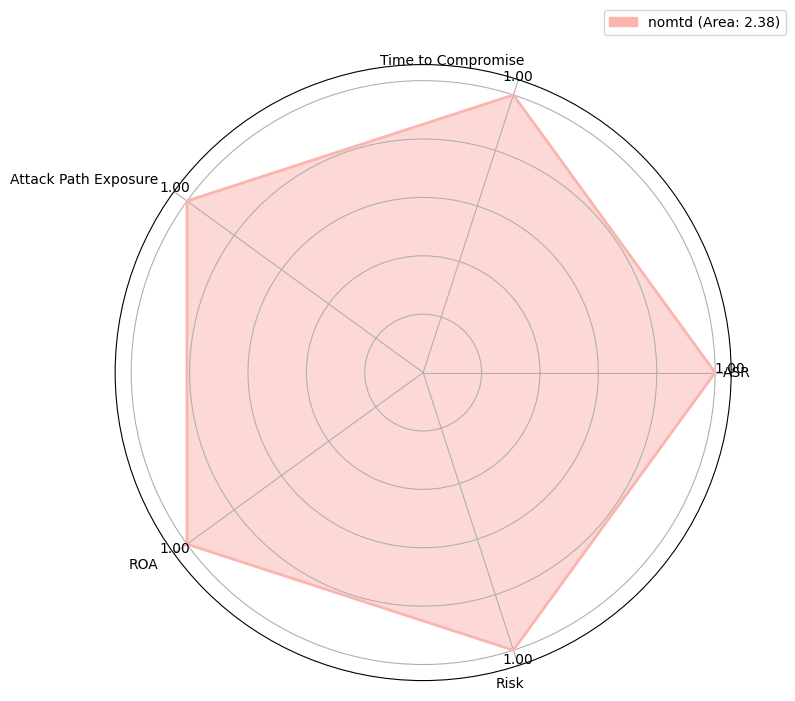

In [27]:
model = 'parameter_set_1'
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial, result_head_path)
schemes_data = radar.scaled_pipeline(scheme='nomtd', data='nomtd', run_trial = False)
radar.plot_n_schemes(schemes_data)

C:\Users\Joo_Kai\AppData\Local\Temp\ipykernel_40188\1814466484.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pastel_colors = cm.get_cmap('Pastel1', len(display_parameters))


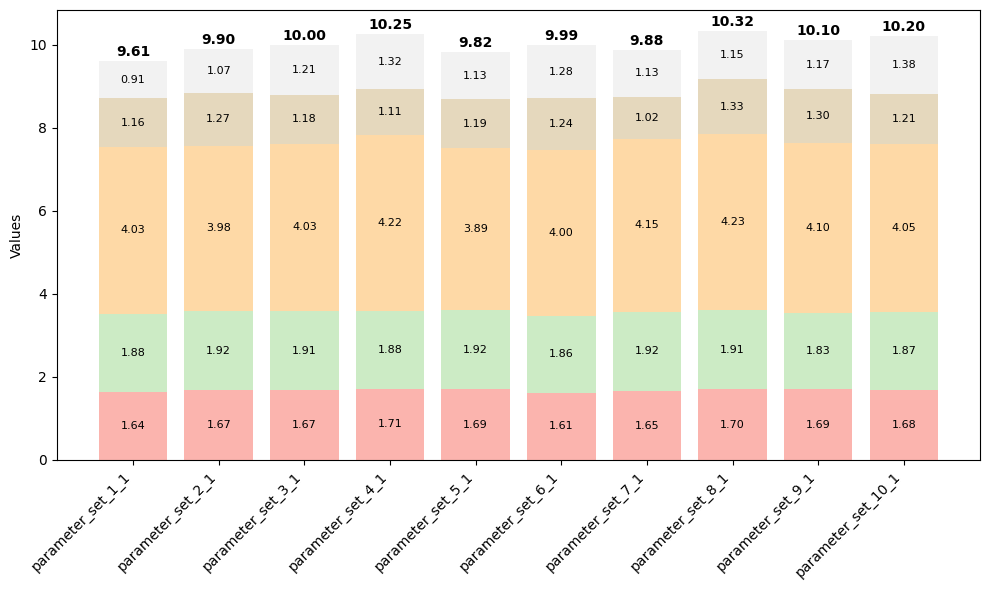

In [42]:
create_stacked_bar_chart(schemes_data)

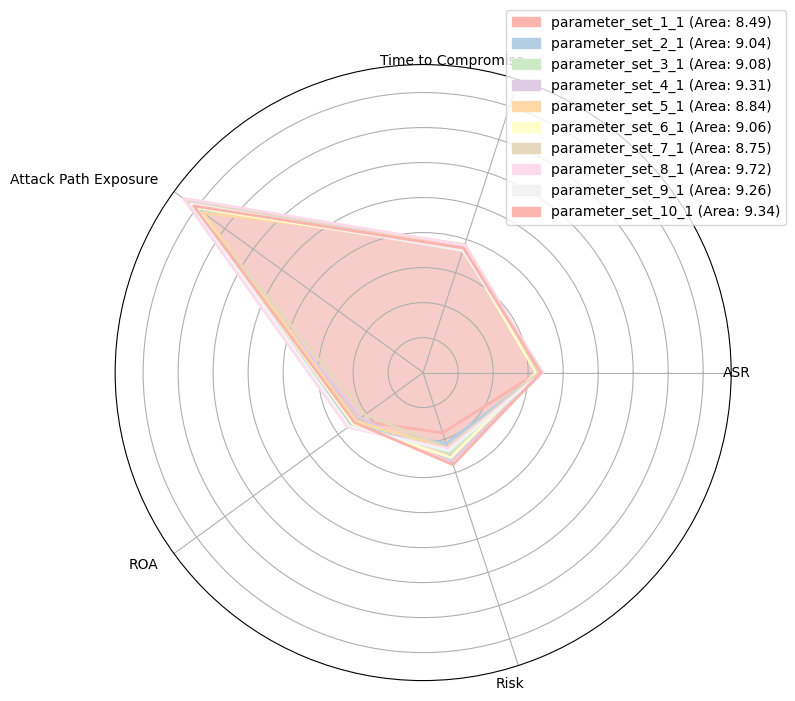

In [35]:
model = 'parameter_set_1'
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial, result_head_path)
schemes_data = radar.multiple_scaled_pipeline(schemes=['parameter_set_1_1', 'parameter_set_2_1', 'parameter_set_3_1', 'parameter_set_4_1', 'parameter_set_5_1', 'parameter_set_6_1', 'parameter_set_7_1', 'parameter_set_8_1', 'parameter_set_9_1', 'parameter_set_10_1'], data_name=['parameter_set_1_1', 'parameter_set_2_1', 'parameter_set_3_1', 'parameter_set_4_1', 'parameter_set_5_1', 'parameter_set_6_1', 'parameter_set_7_1', 'parameter_set_8_1', 'parameter_set_9_1', 'parameter_set_10_1'], run_trial = False)
radar.plot_n_schemes(schemes_data, show_labels=False)

C:\Users\Joo_Kai\AppData\Local\Temp\ipykernel_40188\3218447311.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pastel_colors = cm.get_cmap('Pastel1', len(display_parameters))


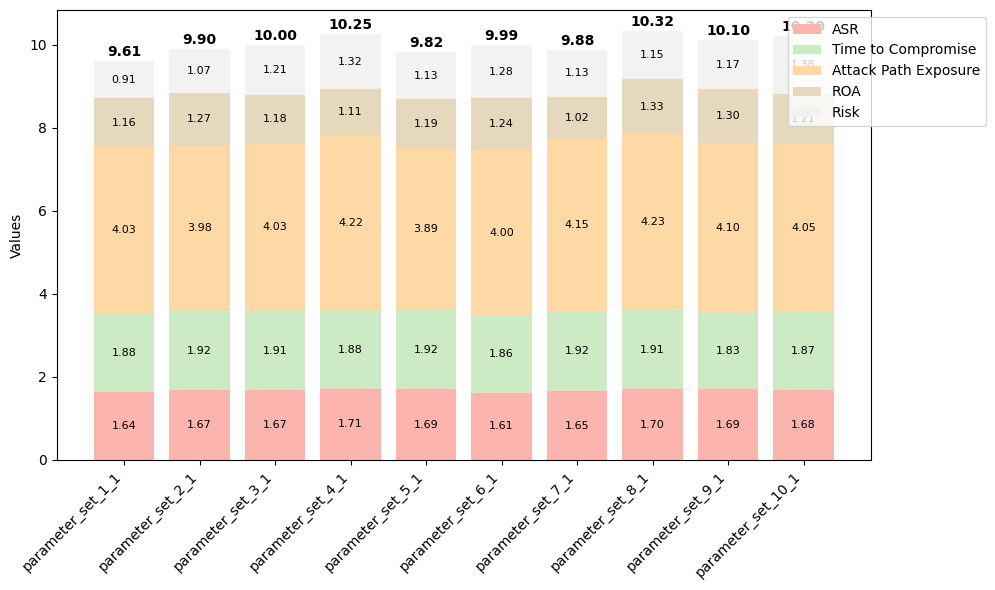

In [36]:
create_stacked_bar_chart(schemes_data)

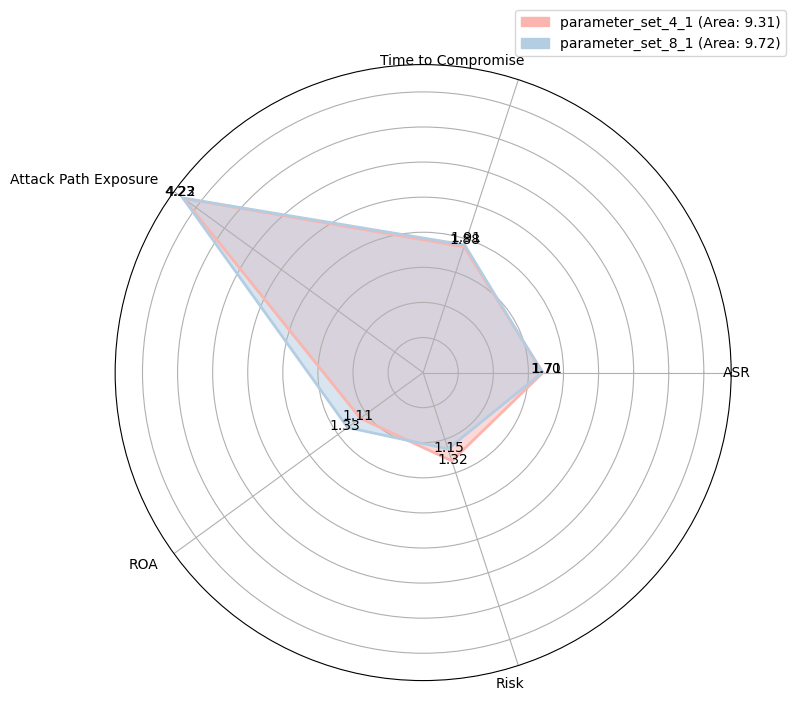

In [10]:
model = 'parameter_set_1'
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial, result_head_path)
schemes_data = radar.multiple_scaled_pipeline(schemes=['parameter_set_4_1', 'parameter_set_8_1'], data_name=['parameter_set_4_1', 'parameter_set_8_1', 'parameter_set_10_1'], run_trial = False)
radar.plot_n_schemes(schemes_data, show_labels=True)

In [11]:
schemes_data

{'parameter_set_4_1': {'mtd_interval': 1.0,
  'MEF': 1,
  'ASR': 1.7068151555501754,
  'time_to_compromise': 1.8846608003625571,
  'host_compromise_ratio': 1.0000000000000002,
  'network_size': 2.0,
  'exposed_endpoints': 1.0,
  'attack_path_exposure': 4.224128355445851,
  'ROA': 1.1073564312789284,
  'risk': 1.3239970736181812,
  'shortest_path_variability': 1},
 'parameter_set_8_1': {'mtd_interval': 1.0,
  'MEF': 1,
  'ASR': 1.6969696969696968,
  'time_to_compromise': 1.9132618879206043,
  'host_compromise_ratio': 1.0000000000000002,
  'network_size': 2.0,
  'exposed_endpoints': 1.0,
  'attack_path_exposure': 4.233271490414349,
  'ROA': 1.3313997338954893,
  'risk': 1.145067434495947,
  'shortest_path_variability': 1}}

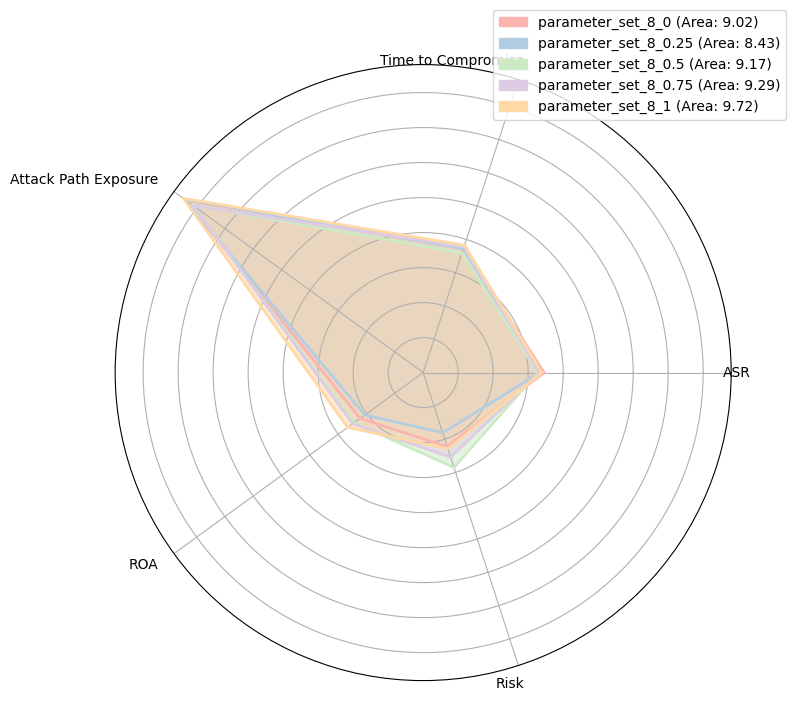

In [44]:
model = 'parameter_set_8'
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial, result_head_path)
schemes_data = radar.multiple_scaled_pipeline(schemes=['parameter_set_8_0', 'parameter_set_8_0.25', 'parameter_set_8_0.5', 'parameter_set_8_0.75', 'parameter_set_8_1'], data_name=['parameter_set_8_0', 'parameter_set_8_0.25', 'parameter_set_8_0.5', 'parameter_set_8_0.75', 'parameter_set_8_1'], run_trial = False)
radar.plot_n_schemes(schemes_data, show_labels=False)

C:\Users\Joo_Kai\AppData\Local\Temp\ipykernel_40188\1814466484.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pastel_colors = cm.get_cmap('Pastel1', len(display_parameters))


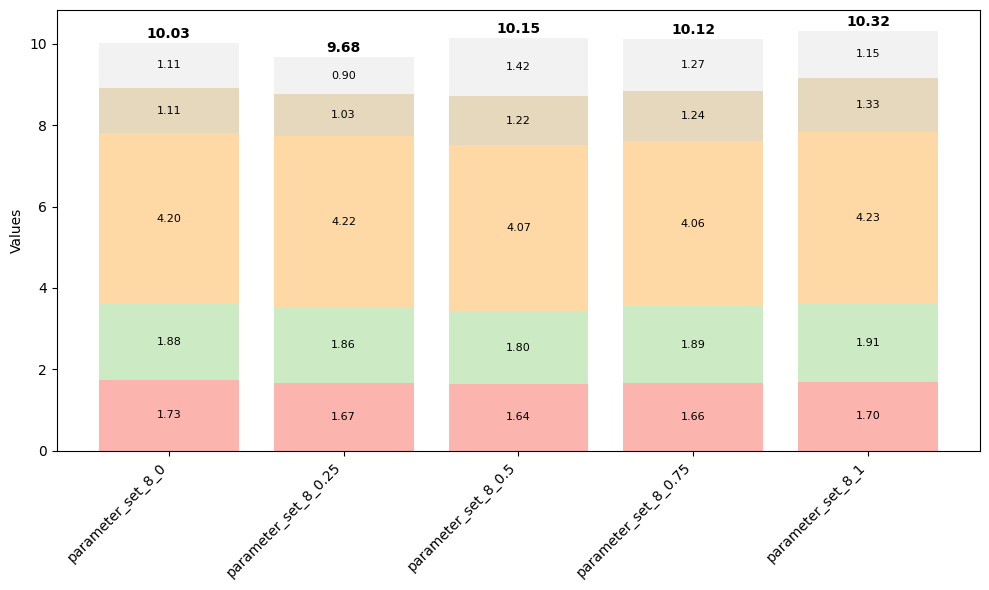

In [45]:
create_stacked_bar_chart(schemes_data)

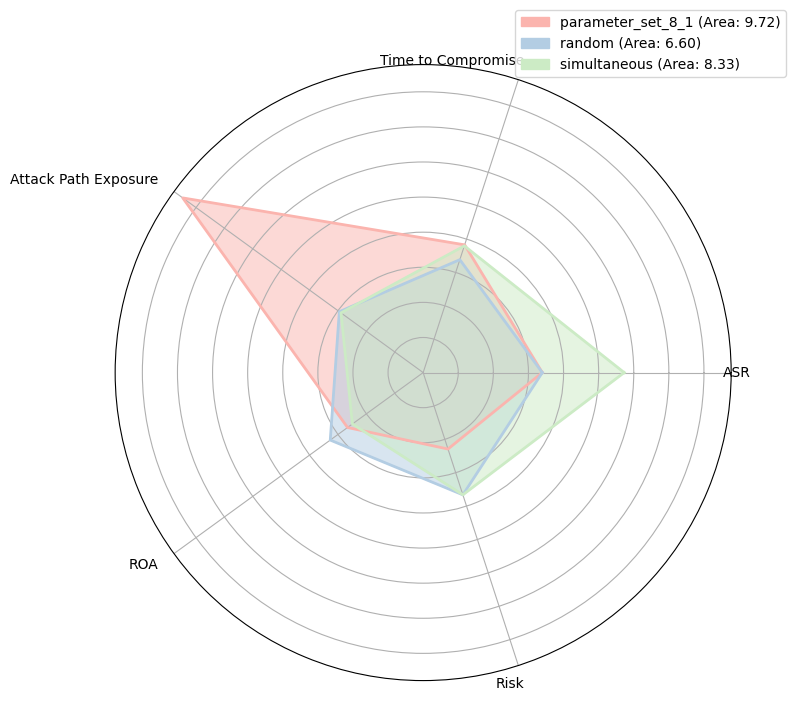

In [46]:
model = 'parameter_set_8'
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial, result_head_path)
schemes_data = radar.multiple_scaled_pipeline(schemes=['parameter_set_8_1', 'random', 'simultaneous'], data_name=['parameter_set_8_1', 'random', 'simultaneous'], run_trial = False)
radar.plot_n_schemes(schemes_data, show_labels=False)

C:\Users\Joo_Kai\AppData\Local\Temp\ipykernel_40188\1814466484.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pastel_colors = cm.get_cmap('Pastel1', len(display_parameters))


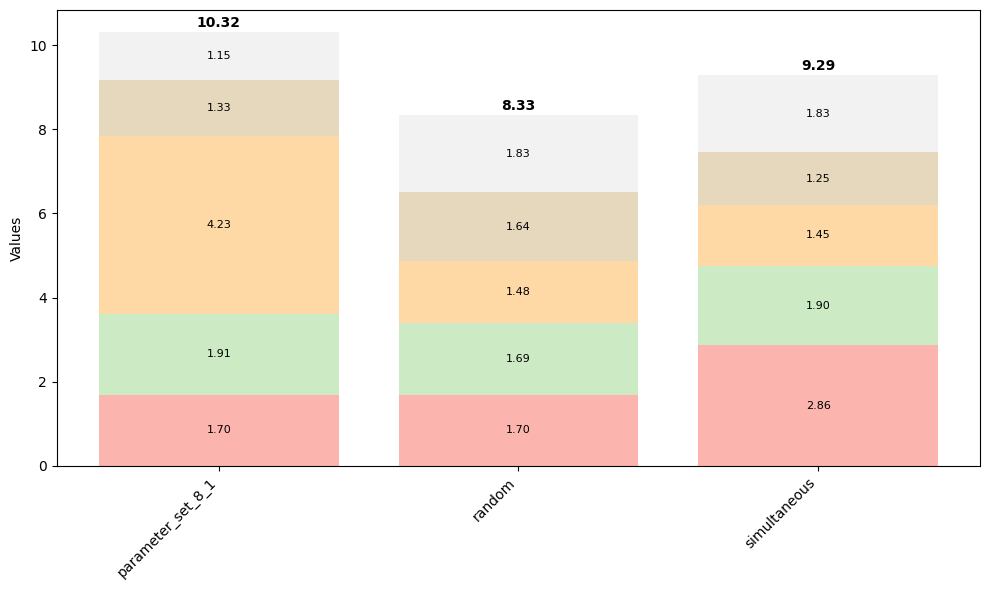

In [47]:
create_stacked_bar_chart(schemes_data)

In [17]:
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network,  model, trial, result_head_path)
schemes_data = radar.scaled_pipeline(scheme='mtdai', data='parameter_set_8_1', run_trial = False)

data_sets = []
mods = ['parameter_set_1_1', 'parameter_set_2_1', 'parameter_set_3_1', 'parameter_set_4_1', 'parameter_set_5_1', 'parameter_set_6_1', 'parameter_set_7_1', 'parameter_set_8_1', 'parameter_set_9_1', 'parameter_set_10_1']
metrics = ['attack_path_exposure', 'time_to_compromise', 'ROA', 'ASR', 'risk']

for mod in mods:
    results = radar.scaled_pipeline(scheme='mtdai', data=mod, run_trial = False)
    data_sets.append(results)

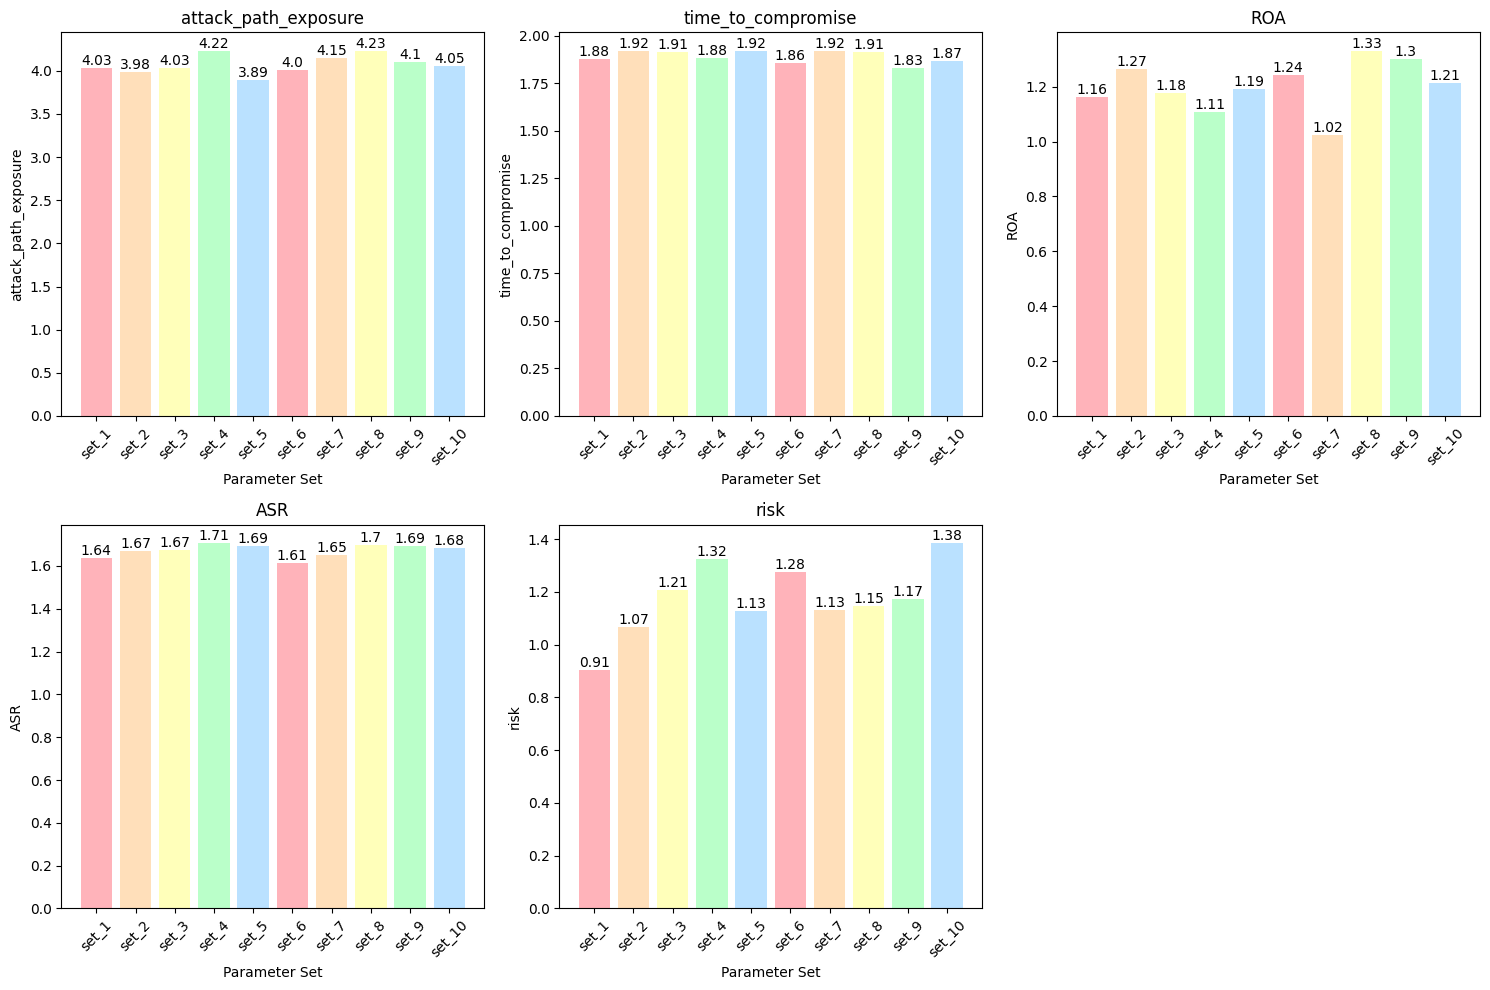

In [18]:
plot_metrics_grid(data_sets, metrics)